In [1]:
import numpy as np
from skimage import color
from torchvision import transforms

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Hugging Face Libraries
from datasets import load_dataset
from diffusers import UNet2DConditionModel, DDPMScheduler, DDIMScheduler
from transformers import CLIPProcessor, CLIPModel


/opt/anaconda3/envs/genai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
class ProjectConfig:
    DATASET_NAME = "uoft-cs/cifar10"
    IMAGE_SIZE = 64  # CIFAR-10 default size
    BATCH_SIZE = 4   # As specified in the proposal (z=4)
    NUM_EPOCHS = 10  # A good starting point for initial training
    LEARNING_RATE = 5e-5
    
    # Lightweight Model configuration
    UNET_CHANNELS = (64, 128, 256)
    CLIP_MODEL = "openai/clip-vit-base-patch32"
    
    # Diffusion settings
    NUM_TRAIN_TIMESTEPS = 1000
    NUM_INFERENCE_STEPS = 20 # Fast DDIM sampling
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = ProjectConfig()
print(f"Using device: {config.DEVICE}")


Using device: cpu


In [3]:
# --- 2.1: Setup CLIP for Conditioning ---
print("Loading CLIP model for conditioning...")
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE)

def get_text_embedding(prompt: str, device):
    """Generates a CLIP text embedding for a given prompt."""
    with torch.no_grad():
        inputs = clip_processor(text=prompt, return_tensors="pt", padding=True).to(device)
        embedding = clip_model.get_text_features(**inputs)
    return embedding

# --- 2.2: Custom Colorization Dataset ---
class ColorizationDataset(Dataset):
    def __init__(self, hf_dataset, cfg):
        self.dataset = hf_dataset
        self.config = cfg
        self.label_names = hf_dataset.features['label'].names

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]
        image = entry['img'].convert("RGB")
        
        # Generate a text prompt from the image's label
        label_index = entry['label']
        label_name = self.label_names[label_index]
        prompt = f"a photo of a {label_name}"

        # Convert from RGB [0, 255] to LAB and normalize to [-1, 1]
        lab_image = color.rgb2lab(np.array(image))
        l_channel = (lab_image[:, :, 0] / 50.0) - 1.0
        ab_channels = lab_image[:, :, 1:] / 128.0
        
        l_tensor = torch.tensor(l_channel, dtype=torch.float32).unsqueeze(0)
        ab_tensor = torch.from_numpy(ab_channels).permute(2, 0, 1).float()
        
        clip_embedding = get_text_embedding(prompt, self.config.DEVICE)
        
        return {
            "l_channel": l_tensor,
            "ab_channels": ab_tensor,
            "clip_embedding": clip_embedding.squeeze(0),
            "prompt": prompt
        }

# --- 2.3: Load Data and Create DataLoader ---
print("Loading and preparing dataset...")
# Using CIFAR-10 as a stand-in for the "modern images" dataset
hf_dataset = load_dataset(config.DATASET_NAME, split="train")

train_dataset = ColorizationDataset(hf_dataset, config)
# Using a smaller subset for a quick training demonstration
subset_indices = range(2000) # Corresponds to your 2,000 modern images
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_dataloader = DataLoader(train_subset, batch_size=config.BATCH_SIZE, shuffle=True)
print("Data preparation complete.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIP model for conditioning...
Loading and preparing dataset...
Data preparation complete.


In [ ]:
print("\nCreating the conditional U-Net model...")
model = UNet2DConditionModel(
    sample_size=config.IMAGE_SIZE,
    in_channels=3,  # 1 for L channel + 2 for noisy AB channels
    out_channels=2, # Predicting noise for the 2 AB channels
    layers_per_block=2,
    block_out_channels=config.UNET_CHANNELS,
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
    cross_attention_dim=clip_model.config.text_config.hidden_size
).to(config.DEVICE)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params / 1e6:.2f}M parameters.")



Creating the conditional U-Net model...
Model has 16.05M parameters.


In [5]:
# --- Part 4: The Training Loop (Corrected) ---

print("\nStarting training...")
noise_scheduler = DDPMScheduler(num_train_timesteps=config.NUM_TRAIN_TIMESTEPS, beta_schedule='squaredcos_cap_v2')
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
scaler = GradScaler() 

losses = []
for epoch in range(config.NUM_EPOCHS):
    model.train()
    progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}")
    
    for step, batch in enumerate(train_dataloader):
        l_channel = batch['l_channel'].to(config.DEVICE)
        true_ab_channels = batch['ab_channels'].to(config.DEVICE)
        clip_embeddings = batch['clip_embedding'].to(config.DEVICE)
        
        noise = torch.randn_like(true_ab_channels)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (l_channel.shape[0],), device=config.DEVICE).long()
        noisy_ab_channels = noise_scheduler.add_noise(true_ab_channels, noise, timesteps)
        
        model_input = torch.cat([noisy_ab_channels, l_channel], dim=1)
        
        optimizer.zero_grad()
        
        with autocast():

            # 1. Unsqueeze the CLIP embeddings to add a sequence dimension.
            # Shape changes from [batch_size, dim] to [batch_size, 1, dim].
            clip_embeddings = clip_embeddings.unsqueeze(1)

            # Pass the correctly shaped embeddings to the model.
            model_output = model(
                sample=model_input,
                timestep=timesteps,
                encoder_hidden_states=clip_embeddings,
            )

            # 2. Safely access the output tensor.
            # Newer diffusers versions return an object with a .sample attribute.
            # Older versions returned the tensor directly. This handles both cases.
            noise_pred = model_output.sample if hasattr(model_output, 'sample') else model_output
            
            # --- END OF FIX ---

            loss = F.mse_loss(noise_pred, noise)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())
        losses.append(loss.item())

    progress_bar.close()

print("Training complete.")


/var/folders/6l/6xvjm1rj3s91m4xr_4g_t7vw0000gn/T/ipykernel_9207/128558573.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/envs/genai/lib/python3.10/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



Starting training...


Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/6l/6xvjm1rj3s91m4xr_4g_t7vw0000gn/T/ipykernel_9207/128558573.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/genai/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 10: 100%|██████████| 500/500 [02:28<00:00,  3.36it/s, loss=0.0057] 

Training complete.



Running inference on a sample image...


Colorizing: 100%|██████████| 20/20 [00:00<00:00, 51.39it/s]


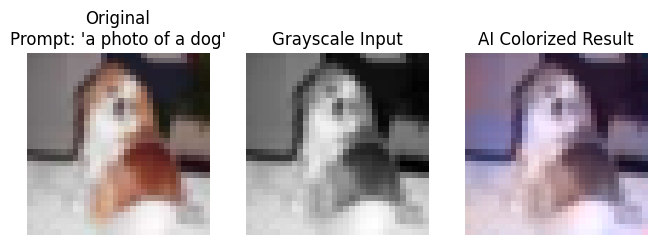

In [9]:
# --- Part 5: Inference & Visualization (Corrected) ---

def colorize_image(l_channel_tensor, prompt, model, cfg, device):
    """Colorizes a single L-channel tensor using the trained diffusion model."""
    model.eval()
    
    # Set up the fast DDIM sampler
    sampler = DDIMScheduler.from_config(noise_scheduler.config)
    sampler.set_timesteps(cfg.NUM_INFERENCE_STEPS)
    
    # Start with random noise for the AB channels
    ab_channels = torch.randn(1, 2, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, device=device)
    
    # Get the conditioning text embedding
    clip_embedding = get_text_embedding(prompt, device)
    
    for t in tqdm(sampler.timesteps, desc="Colorizing"):
        with torch.no_grad():
            # Concatenate L channel as a condition to the noisy AB channels
            model_input = torch.cat([ab_channels, l_channel_tensor], dim=1)

            # --- THE FIX IS HERE ---
            
            # 1. Unsqueeze the CLIP embeddings to add the sequence dimension.
            # Shape changes from [1, dim] to [1, 1, dim].
            clip_embeddings_unsqueezed = clip_embedding.unsqueeze(1)

            # Pass the correctly shaped embeddings to the model
            model_output = model(
                sample=model_input,
                timestep=t,
                encoder_hidden_states=clip_embeddings_unsqueezed
            )

            # 2. Safely access the output tensor
            predicted_noise = model_output.sample if hasattr(model_output, 'sample') else model_output

            # --- END OF FIX ---
            
            # Use the sampler to compute the previous noisy sample
            ab_channels = sampler.step(predicted_noise, t, ab_channels).prev_sample
            
    # --- Post-processing to convert LAB back to RGB ---
    l_np = (l_channel_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1.0) * 50.0
    ab_np = ab_channels.squeeze(0).permute(1, 2, 0).cpu().numpy() * 128.0
    
    lab_restored = np.concatenate([l_np, ab_np], axis=-1)
    lab_restored = np.clip(lab_restored, [[0, -128, -128]], [[100, 127, 127]])
    rgb_restored = color.lab2rgb(lab_restored)
    
    return Image.fromarray((rgb_restored * 255).astype(np.uint8))


# --- Visualize a Result ---
print("\nRunning inference on a sample image...")

# Select a sample from the dataset to test
sample_idx = 42 # You can change this index to try different images
data_sample = train_dataset[sample_idx]
l_input_tensor = data_sample['l_channel'].unsqueeze(0).to(config.DEVICE)
text_prompt = data_sample['prompt']

# Generate the colorized version
colorized_result = colorize_image(l_input_tensor, text_prompt, model, config, config.DEVICE)

# --- Display side-by-side comparison ---
original_image = hf_dataset[sample_idx]['img'].resize((config.IMAGE_SIZE, config.IMAGE_SIZE))
grayscale_image = original_image.convert('L')

fig, axs = plt.subplots(1, 3, figsize=(8, 4))
axs[0].imshow(original_image)
axs[0].set_title(f"Original\nPrompt: '{text_prompt}'")
axs[0].axis('off')

# --- Plot 2: Grayscale Input (The new addition) ---
axs[1].imshow(grayscale_image, cmap='gray') # Use cmap='gray' for correct rendering
axs[1].set_title("Grayscale Input")
axs[1].axis('off')

# --- Plot 3: AI Colorized Result (Moved from index 1 to 2) ---
axs[2].imshow(colorized_result)
axs[2].set_title("AI Colorized Result")
axs[2].axis('off')

plt.show()


In [10]:
def colorize_external_image(image_path, prompt_text, model, cfg, device):
    """
    Loads an external image, preprocesses it, and colorizes it using the model.

    Args:
        image_path (str): The file path to the image (e.g., 'my_photo.jpg').
        prompt_text (str): The descriptive text prompt for the image content.
        model: The trained U-Net model.
        cfg: The project configuration object.
        device: The device to run the model on ('cuda' or 'cpu').
    """
    print(f"Loading image from: {image_path}")
    # 1. Load the image and convert to RGB (ensures 3 channels)
    img = Image.open(image_path).convert("RGB")
    
    # 2. Preprocess the image to match the model's input requirements
    
    # Resize to the model's expected input size
    img_resized = img.resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    
    # Convert from RGB [0, 255] to LAB and normalize
    lab_image = color.rgb2lab(np.array(img_resized))
    
    # Extract L channel and normalize to [-1, 1]
    l_channel = (lab_image[:, :, 0] / 50.0) - 1.0
    
    # Convert to a PyTorch tensor with the correct dimensions (batch, channel, H, W)
    l_tensor = torch.tensor(l_channel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    l_input_tensor = l_tensor.to(device)
    
    print(f"Using prompt: '{prompt_text}'")
    # 3. Run the colorization function
    colorized_result = colorize_image(l_input_tensor, prompt_text, model, cfg, device)
    
    # 4. Display the results
    grayscale_image = img_resized.convert('L')
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    
    axs[0].imshow(img_resized)
    axs[0].set_title("Original Input")
    axs[0].axis('off')

    axs[1].imshow(grayscale_image, cmap='gray')
    axs[1].set_title("Grayscale (Model's Input)")
    axs[1].axis('off')

    axs[2].imshow(colorized_result)
    axs[2].set_title("AI Colorized Result")
    axs[2].axis('off')

    plt.suptitle(f"Prompt: \"{prompt_text}\"", fontsize=14)
    plt.show()

    return colorized_result


Loading image from: /Users/manikeshmakam/Downloads/pic1.jpg
Using prompt: 'A high quality photo of a vintage boxing match under stadium lights.'


Colorizing: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s]
/var/folders/6l/6xvjm1rj3s91m4xr_4g_t7vw0000gn/T/ipykernel_9207/3166632066.py:49: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 29 negative Z values that have been clipped to zero
  rgb_restored = color.lab2rgb(lab_restored)


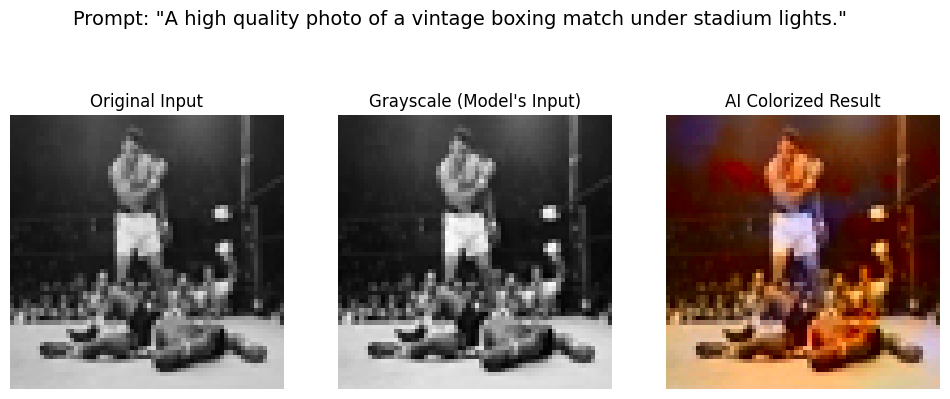

Loading image from: /Users/manikeshmakam/Downloads/pic2.webp
Using prompt: 'A high quality photo of a batsman playing a shot on a grassy cricket field.'


Colorizing: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s]
/var/folders/6l/6xvjm1rj3s91m4xr_4g_t7vw0000gn/T/ipykernel_9207/3166632066.py:49: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  rgb_restored = color.lab2rgb(lab_restored)


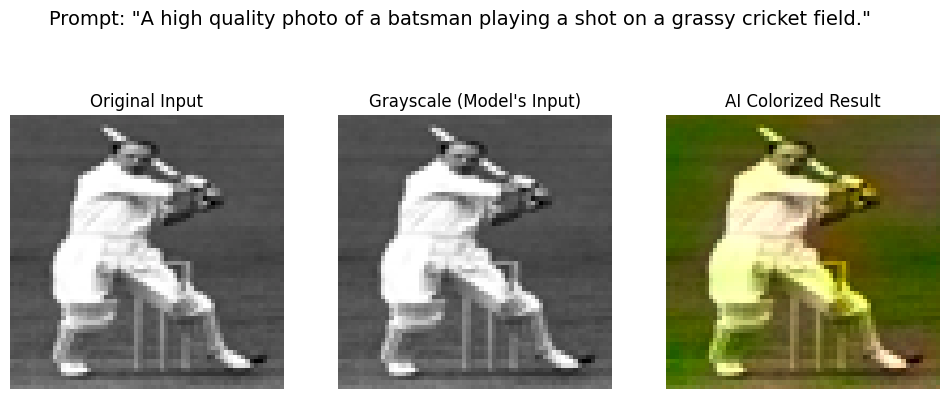

Loading image from: /Users/manikeshmakam/Downloads/pic3.jpg
Using prompt: 'A high quality photo of a baseball player swinging a bat in an old stadium.'


Colorizing: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


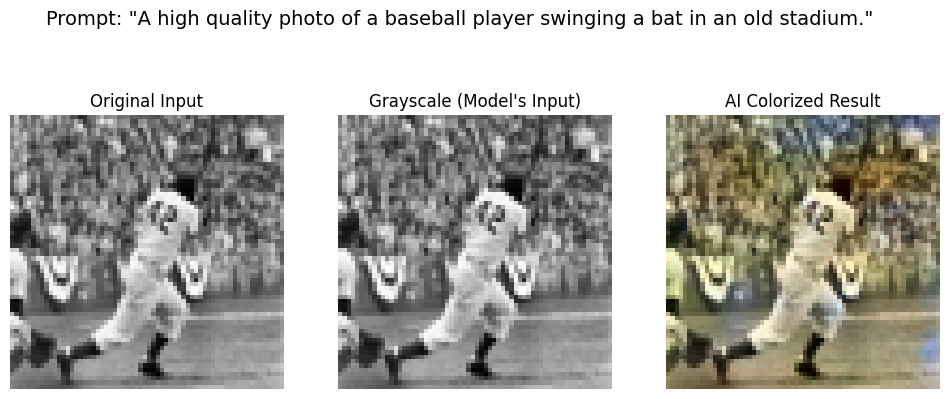

Loading image from: /Users/manikeshmakam/Downloads/pic4.jpg
Using prompt: 'A high quality photo of a sprinter mid-race on a cinder track in front of a large crowd.'


Colorizing: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]
/var/folders/6l/6xvjm1rj3s91m4xr_4g_t7vw0000gn/T/ipykernel_9207/3166632066.py:49: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  rgb_restored = color.lab2rgb(lab_restored)


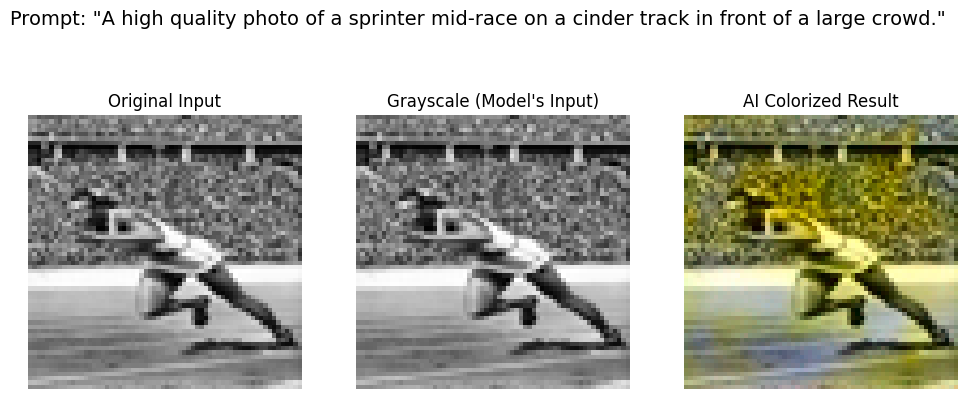

Loading image from: /Users/manikeshmakam/Downloads/pic5.jpg
Using prompt: 'A high quality photo of a football player taking a shot during an old match in a full stadium.'


Colorizing: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


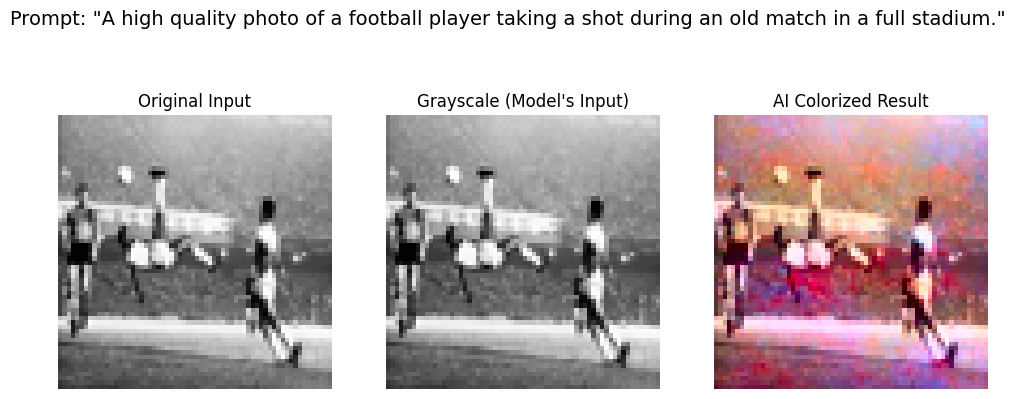

In [23]:
# --- Colorize a custom external image ---
# Ensure the model is in evaluation mode
model.eval()

# Define the path to your image and a descriptive prompt
my_image_path = ["/Users/manikeshmakam/Downloads/pic1.jpg",
                 "/Users/manikeshmakam/Downloads/pic2.webp",
                 "/Users/manikeshmakam/Downloads/pic3.jpg",
                 "/Users/manikeshmakam/Downloads/pic4.jpg",
                 "/Users/manikeshmakam/Downloads/pic5.jpg"]

my_prompt = ["A high quality photo of a vintage boxing match under stadium lights.",
             "A high quality photo of a batsman playing a shot on a grassy cricket field.",
              "A high quality photo of a baseball player swinging a bat in an old stadium.",
               "A high quality photo of a sprinter mid-race on a cinder track in front of a large crowd.",
                "A high quality photo of a football player taking a shot during an old match in a full stadium."] # <-- CHANGE THIS to describe your image

# Call the new function to process and display the result
# Make sure to create the image file 'cat_bw.jpg' or change the path.
try:
    for i in range(len(my_image_path)):
        generated_image = colorize_external_image(my_image_path[i], my_prompt[i], model, config, config.DEVICE)
except FileNotFoundError:
    print(f"\nERROR: The file '{my_image_path}' was not found.")
    print("Please add an image file with that name to the directory or update the path.")
